In [29]:
from tqdm import tqdm
import pickle
import pandas as pd
from pathlib import Path
import numpy as np
import scipy
import copy
import sys
import os
from typing import Optional, Union, Sequence, Mapping, List, Set
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from matplotlib.lines import Line2D
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

sys.path.append('/mnt/c/Users/lslat/Code/')
sys.path.append('/mnt/c/Users/lslat/QiskitProjects/VariationalWavefunction/')

from quantum_kernel.code.utils import get_dataset
from quantum_kernel.code.visualization_utils import aggregate_shapes,filter_df
from quantum_kernel.code.kernel_measures.kernel_geometry import purity_average, purity_of_average,geometric_difference,geometric_distance
from quantum_kernel.code.kernel_measures.eigenvalue_scaling import get_eigenvalue_scaling,compute_dataframe_kernel_eigenvalues

font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 18}

rc('font', **font)

tqdm.pandas()
warnings.filterwarnings("ignore")


In [30]:
# Get kernel results for the different ml models and dataset.d
dfs = {}
gamma=0.2
beta=1.0
folders = [
    ("/mnt/c/Users/lslat/Data/QK_project/results/Sparse_IQP/gennorm/gamma{}/".format(gamma),'Sparse_IQP'),
]

for folder,prefix in folders:
    if prefix in dfs:
        temp = aggregate_shapes(folder,prefix)
        dfs[prefix] = pd.concat([dfs[prefix], temp])
    else:
        dfs[prefix] = aggregate_shapes(folder,prefix)


In [31]:
save_folder='/mnt/c/Users/lslat/Data/QK_project/results/figs/'

In [32]:
iqp_df=dfs['Sparse_IQP']

Create data frames for the classical and quantum iqp with the appropriate beta value for our distribution.

In [33]:
qiqp_df=iqp_df[(iqp_df['density']!=0) & (iqp_df['beta']==beta)]
ciqp_df=iqp_df[(iqp_df['density']==0) & (iqp_df['beta']==beta)]

Add kernel eigenvalues to data frames

In [34]:
qiqp_df=compute_dataframe_kernel_eigenvalues(qiqp_df)
ciqp_df=compute_dataframe_kernel_eigenvalues(ciqp_df)

Check to make sure that all max kernel eigenvalues are close to the target of gamma = 0.2 predicted by the interpolation we did. For final data I should produce more points and fit the line. Instead of doing the interpolation method.

Text(0.5, 1.0, 'Max Kernel Eigenvalues for target $\\gamma=0.2$ IQP circuit')

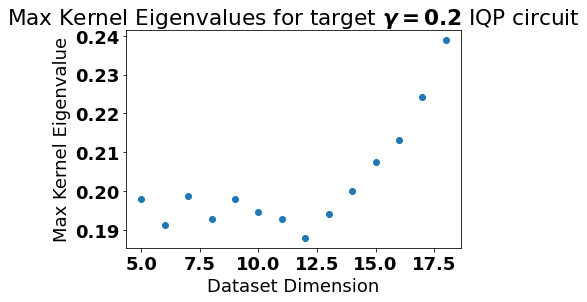

In [35]:
xp=qiqp_df.dataset_dim.values
yp=qiqp_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1).values
plt.scatter(xp,yp)
plt.ylabel('Max Kernel Eigenvalue')
plt.xlabel('Dataset Dimension')
plt.title(r'Max Kernel Eigenvalues for target $\gamma=0.2$ IQP circuit')

Take a look at the eigenvalues we got with the classical iqp circuit.

Text(0.5, 1.0, 'Max Kernel Eigenvalues for "classical" IQP circuit')

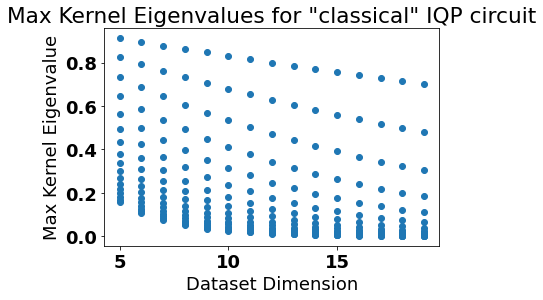

In [36]:
xp=ciqp_df.dataset_dim.values
yp=ciqp_df.apply(lambda x: max(x.kernel_eigenvalues),axis=1).values
plt.scatter(xp,yp)
plt.ylabel('Max Kernel Eigenvalue')
plt.xlabel('Dataset Dimension')
plt.title('Max Kernel Eigenvalues for "classical" IQP circuit')

Compute the geometric difference betwee the quantum iqp kernels and classical iqp kernels with the same dataset dim size.

In [37]:
filepath=save_folder+'geometric_difference_dict.p'

dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_diffs=pickle.load(pickle_file)
else:
    geo_diffs={}
    for dim in dataset_dims:
        c_df=ciqp_df[ciqp_df['dataset_dim']==dim]
        q_df=qiqp_df[qiqp_df['dataset_dim']==dim]
        Kq=q_df.qkern_matrix_train.values[0]
        Kcs=c_df.qkern_matrix_train.values
        sfs=c_df.scaling_factor.values
        geo_diffs[str(dim)]=np.array([(sf,geometric_difference(Kq,Kc)) for sf,Kc in zip(sfs,Kcs)])

    with open(filepath, 'wb') as f:
        try:
            pickle.dump(geo_diffs,f)
        except:
            print('Could not save geo_diffs dictionary')

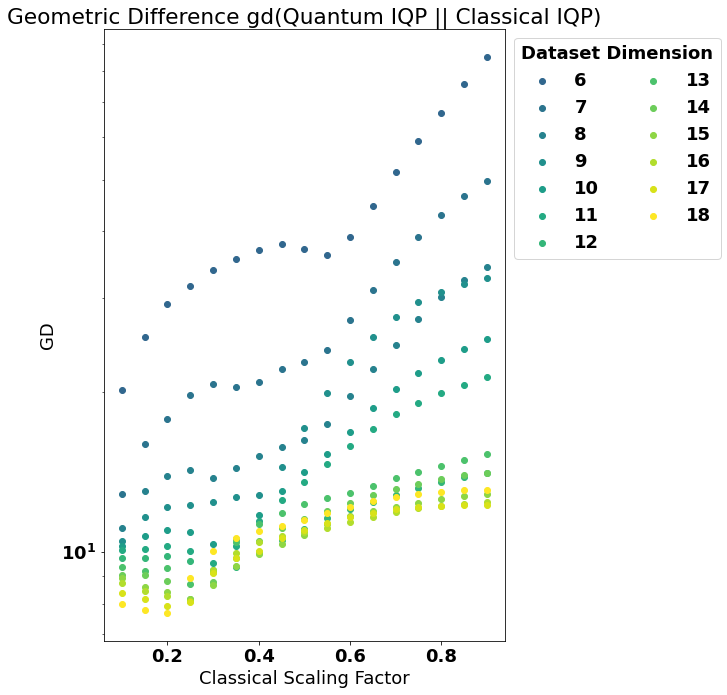

In [43]:
colormap=cm.viridis
dataset_dims=[6,7,8,9,10,11,12,13,14,15,16,17,18]
fig, axs = plt.subplots(1,figsize=(10,10))
ax=axs
for dim in dataset_dims:
    color_index=int(256*dim/max(dataset_dims))-1
    color=colormap.colors[color_index]
    ax.scatter(geo_diffs[str(dim)][:,0],geo_diffs[str(dim)][:,1],color=color,label=dim)

ax.set_yscale('log')
ax.set_ylabel('GD')
ax.set_xlabel('Classical Scaling Factor')  
legend=plt.legend(ncol=2,bbox_to_anchor=(1,1))
legend.set_title('Dataset Dimension')
ax.set_title('Geometric Difference gd(Quantum IQP || Classical IQP)')
fig.tight_layout()
fig.savefig(f'{save_folder}IQP_gd_grid_search.png')

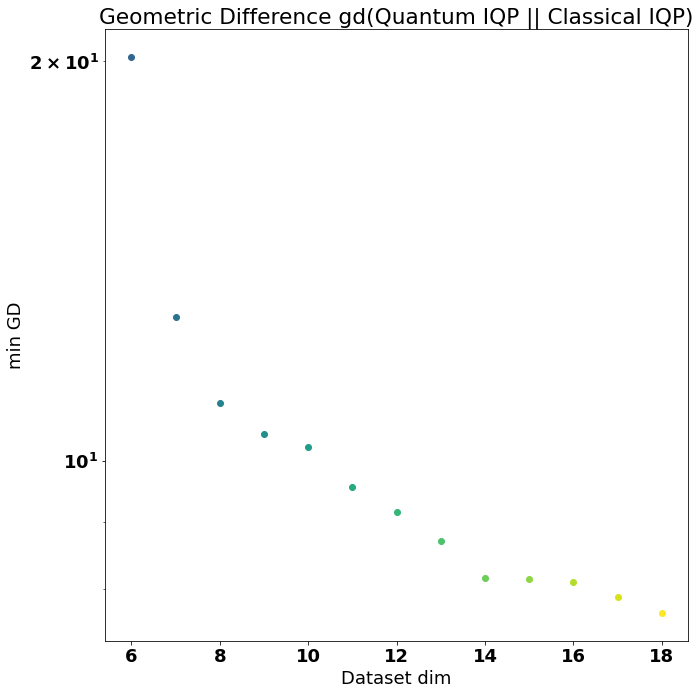

In [44]:
colormap=cm.viridis
dataset_dims=[6,7,8,9,10,11,12,13,14,15,16,17,18]
fig, axs = plt.subplots(1,figsize=(10,10))
ax=axs
for dim in dataset_dims:
    color_index=int(256*dim/max(dataset_dims))-1
    color=colormap.colors[color_index]
    ax.scatter(dim,min(geo_diffs[str(dim)][:,1]),color=color)

ax.set_yscale('log')
ax.set_ylabel('min GD')
ax.set_xlabel('Dataset dim')
ax.set_title('Geometric Difference gd(Quantum IQP || Classical IQP)')
fig.tight_layout()
fig.savefig(f'{save_folder}IQP_min_gd_plot.png')

Compute the geometric difference betwee the quantum iqp kernels and classical iqp kernels (reversed order from previous case) with the same dataset dim size.

In [ ]:
filepath=save_folder+'rev_geometric_difference_dict.p'

dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        rgeo_diffs=pickle.load(pickle_file)
else:
    rgeo_diffs={}
    for dim in dataset_dims:
        c_df=ciqp_df[ciqp_df['dataset_dim']==dim]
        q_df=qiqp_df[qiqp_df['dataset_dim']==dim]
        Kq=q_df.qkern_matrix_train.values[0]
        Kcs=c_df.qkern_matrix_train.values
        sfs=c_df.scaling_factor.values
        rgeo_diffs[str(dim)]=np.array([(sf,geometric_difference(Kq,Kc)) for sf,Kc in zip(sfs,Kcs)])

    with open(filepath, 'wb') as f:
        try:
            pickle.dump(rgeo_diffs,f)
        except:
            print('Could not save geo_diffs dictionary')

Text(0.5, 1.0, 'Geometric Difference gd(Classical IQP || Quantum IQP)')

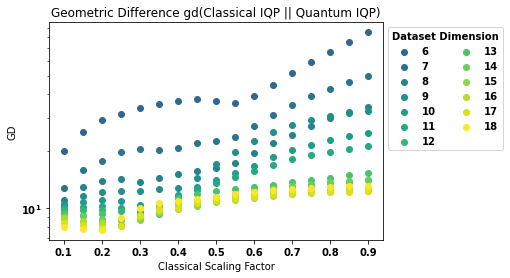

In [ ]:
colormap=cm.viridis
dataset_dims=[6,7,8,9,10,11,12,13,14,15,16,17,18]
for dim in dataset_dims:
    color_index=int(256*dim/max(dataset_dims))-1
    color=colormap.colors[color_index]
    plt.scatter(rgeo_diffs[str(dim)][:,0],rgeo_diffs[str(dim)][:,1],color=color,label=dim)

plt.yscale('log')
plt.ylabel('GD')
plt.xlabel('Classical Scaling Factor')
legend=plt.legend(ncol=2,bbox_to_anchor=(1,1))
legend.set_title('Dataset Dimension')
plt.title('Geometric Difference gd(Classical IQP || Quantum IQP)')

Text(0.5, 1.0, 'Geometric Difference gd(Classical IQP || Quantum IQP)')

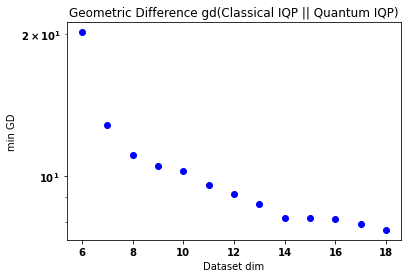

In [ ]:
colormap=cm.viridis
dataset_dims=[6,7,8,9,10,11,12,13,14,15,16,17,18]
for dim in dataset_dims:
    plt.scatter(dim,min(rgeo_diffs[str(dim)][:,1]),color='blue')

plt.yscale('log')
plt.ylabel('min GD')
plt.xlabel('Dataset dim')  
plt.title('Geometric Difference gd(Classical IQP || Quantum IQP)')



In [ ]:
filepath=save_folder+'geometric_distance_dict.p'

dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
if os.path.exists(filepath):
    with open(filepath, 'rb') as pickle_file:
        geo_dists=pickle.load(pickle_file)
else:
    geo_dists={}
    for dim in dataset_dims:
        c_df=ciqp_df[ciqp_df['dataset_dim']==dim]
        q_df=qiqp_df[qiqp_df['dataset_dim']==dim]
        Kq=q_df.qkern_matrix_train.values[0]
        Kcs=c_df.qkern_matrix_train.values
        sfs=c_df.scaling_factor.values
        geo_dists[str(dim)]=np.array([(sf,geometric_distance(Kq,Kc)) for sf,Kc in zip(sfs,Kcs)])

    with open(filepath, 'wb') as f:
        try:
            pickle.dump(geo_dists,f)
        except:
            print('Could not save geo_diffs dictionary')

Text(0.5, 1.0, 'Geometric Distance')

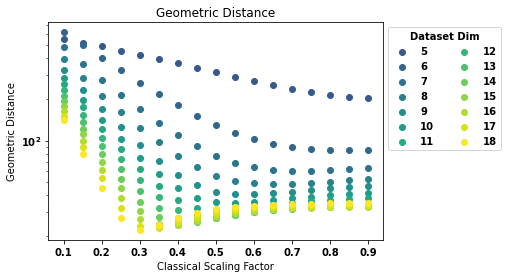

In [ ]:
colormap=cm.viridis
dataset_dims=[5,6,7,8,9,10,11,12,13,14,15,16,17,18]
for dim in dataset_dims:
    color_index=int(256*dim/max(dataset_dims))-1
    color=colormap.colors[color_index]
    plt.scatter(geo_dists[str(dim)][:,0],geo_dists[str(dim)][:,1],color=color,label=dim)
    
plt.yscale('log')
plt.ylabel('Geometric Distance')
plt.xlabel('Classical Scaling Factor')
legend=plt.legend(ncol=2,bbox_to_anchor=(1,1))
legend.set_title('Dataset Dim')
plt.title('Geometric Distance')

Text(0.5, 1.0, 'Geometric Distance')

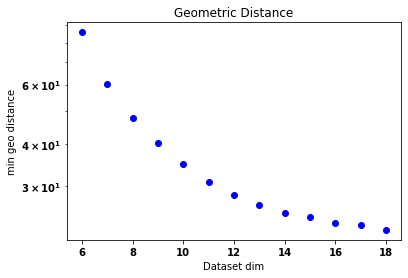

In [ ]:
colormap=cm.viridis
dataset_dims=[6,7,8,9,10,11,12,13,14,15,16,17,18]
for dim in dataset_dims:
    plt.scatter(dim,min(geo_dists[str(dim)][:,1]),color='blue')

plt.yscale('log')
plt.ylabel('min geo distance')
plt.xlabel('Dataset dim')  
plt.title('Geometric Distance')